In [127]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import pandas as pd
import matplotlib.lines as mlines


In [ ]:
current_folder = os.getcwd()
root_dir = os.path.dirname(current_folder)
sys.path.append(root_dir+'/implementation')
sys.path.append(root_dir)


In [9]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

In [10]:
dataset = 'healthcare' #choose 'healthcare' or 'airquality'
datafolder = 'Imputation/PhysioNet/n_samples_100_run_10_missing_ratio_0.1/Pretrained' # set the folder name
nsample = 100 # number of generated sample

path = root_dir+'/save/'+datafolder+'/generated_outputs_Test_nsample' + str(nsample) + '.pk' 
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,all_labels,scaler,mean_scaler = pickle.load( f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

In [11]:

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

ELEMENT (25, 27)
[(25, 27), (29, 32), (45, 47)] 3
ELEMENT (17, 19)
[(17, 19), (37, 39), (44, 46)] 3
[] 0
ELEMENT (3, 8)
[(3, 8), (11, 20), (34, 48)] 3
ELEMENT (1, 3)
[(1, 3), (21, 33)] 2
ELEMENT (5, 10)
[(5, 10)] 1
ELEMENT (0, 18)
[(0, 18)] 1
[] 0
[] 0
[] 0
ELEMENT (3, 11)
[(3, 11), (18, 36)] 2
[] 0
ELEMENT (0, 3)
[(0, 3), (12, 19)] 2
[] 0
[] 0
ELEMENT (7, 18)
[(7, 18), (25, 46)] 2
[] 0
[] 0
ELEMENT (25, 46)
[(25, 46)] 1
[] 0
ELEMENT (15, 17)
[(15, 17), (20, 22), (23, 25), (30, 34)] 4
[] 0
[] 0
ELEMENT (15, 23)
[(15, 23)] 1
[] 0
ELEMENT (5, 7)
[(5, 7), (9, 11), (35, 39), (40, 48)] 4
[] 0
ELEMENT (12, 14)
[(12, 14), (32, 34), (37, 39)] 3
[] 0
ELEMENT (19, 28)
[(19, 28), (36, 42)] 2
ELEMENT (36, 48)
[(36, 48)] 1
ELEMENT (9, 13)
[(9, 13), (14, 16), (19, 21)] 3
ELEMENT (0, 2)
[(0, 2)] 1
ELEMENT (25, 46)
[(25, 46)] 1
[] 0


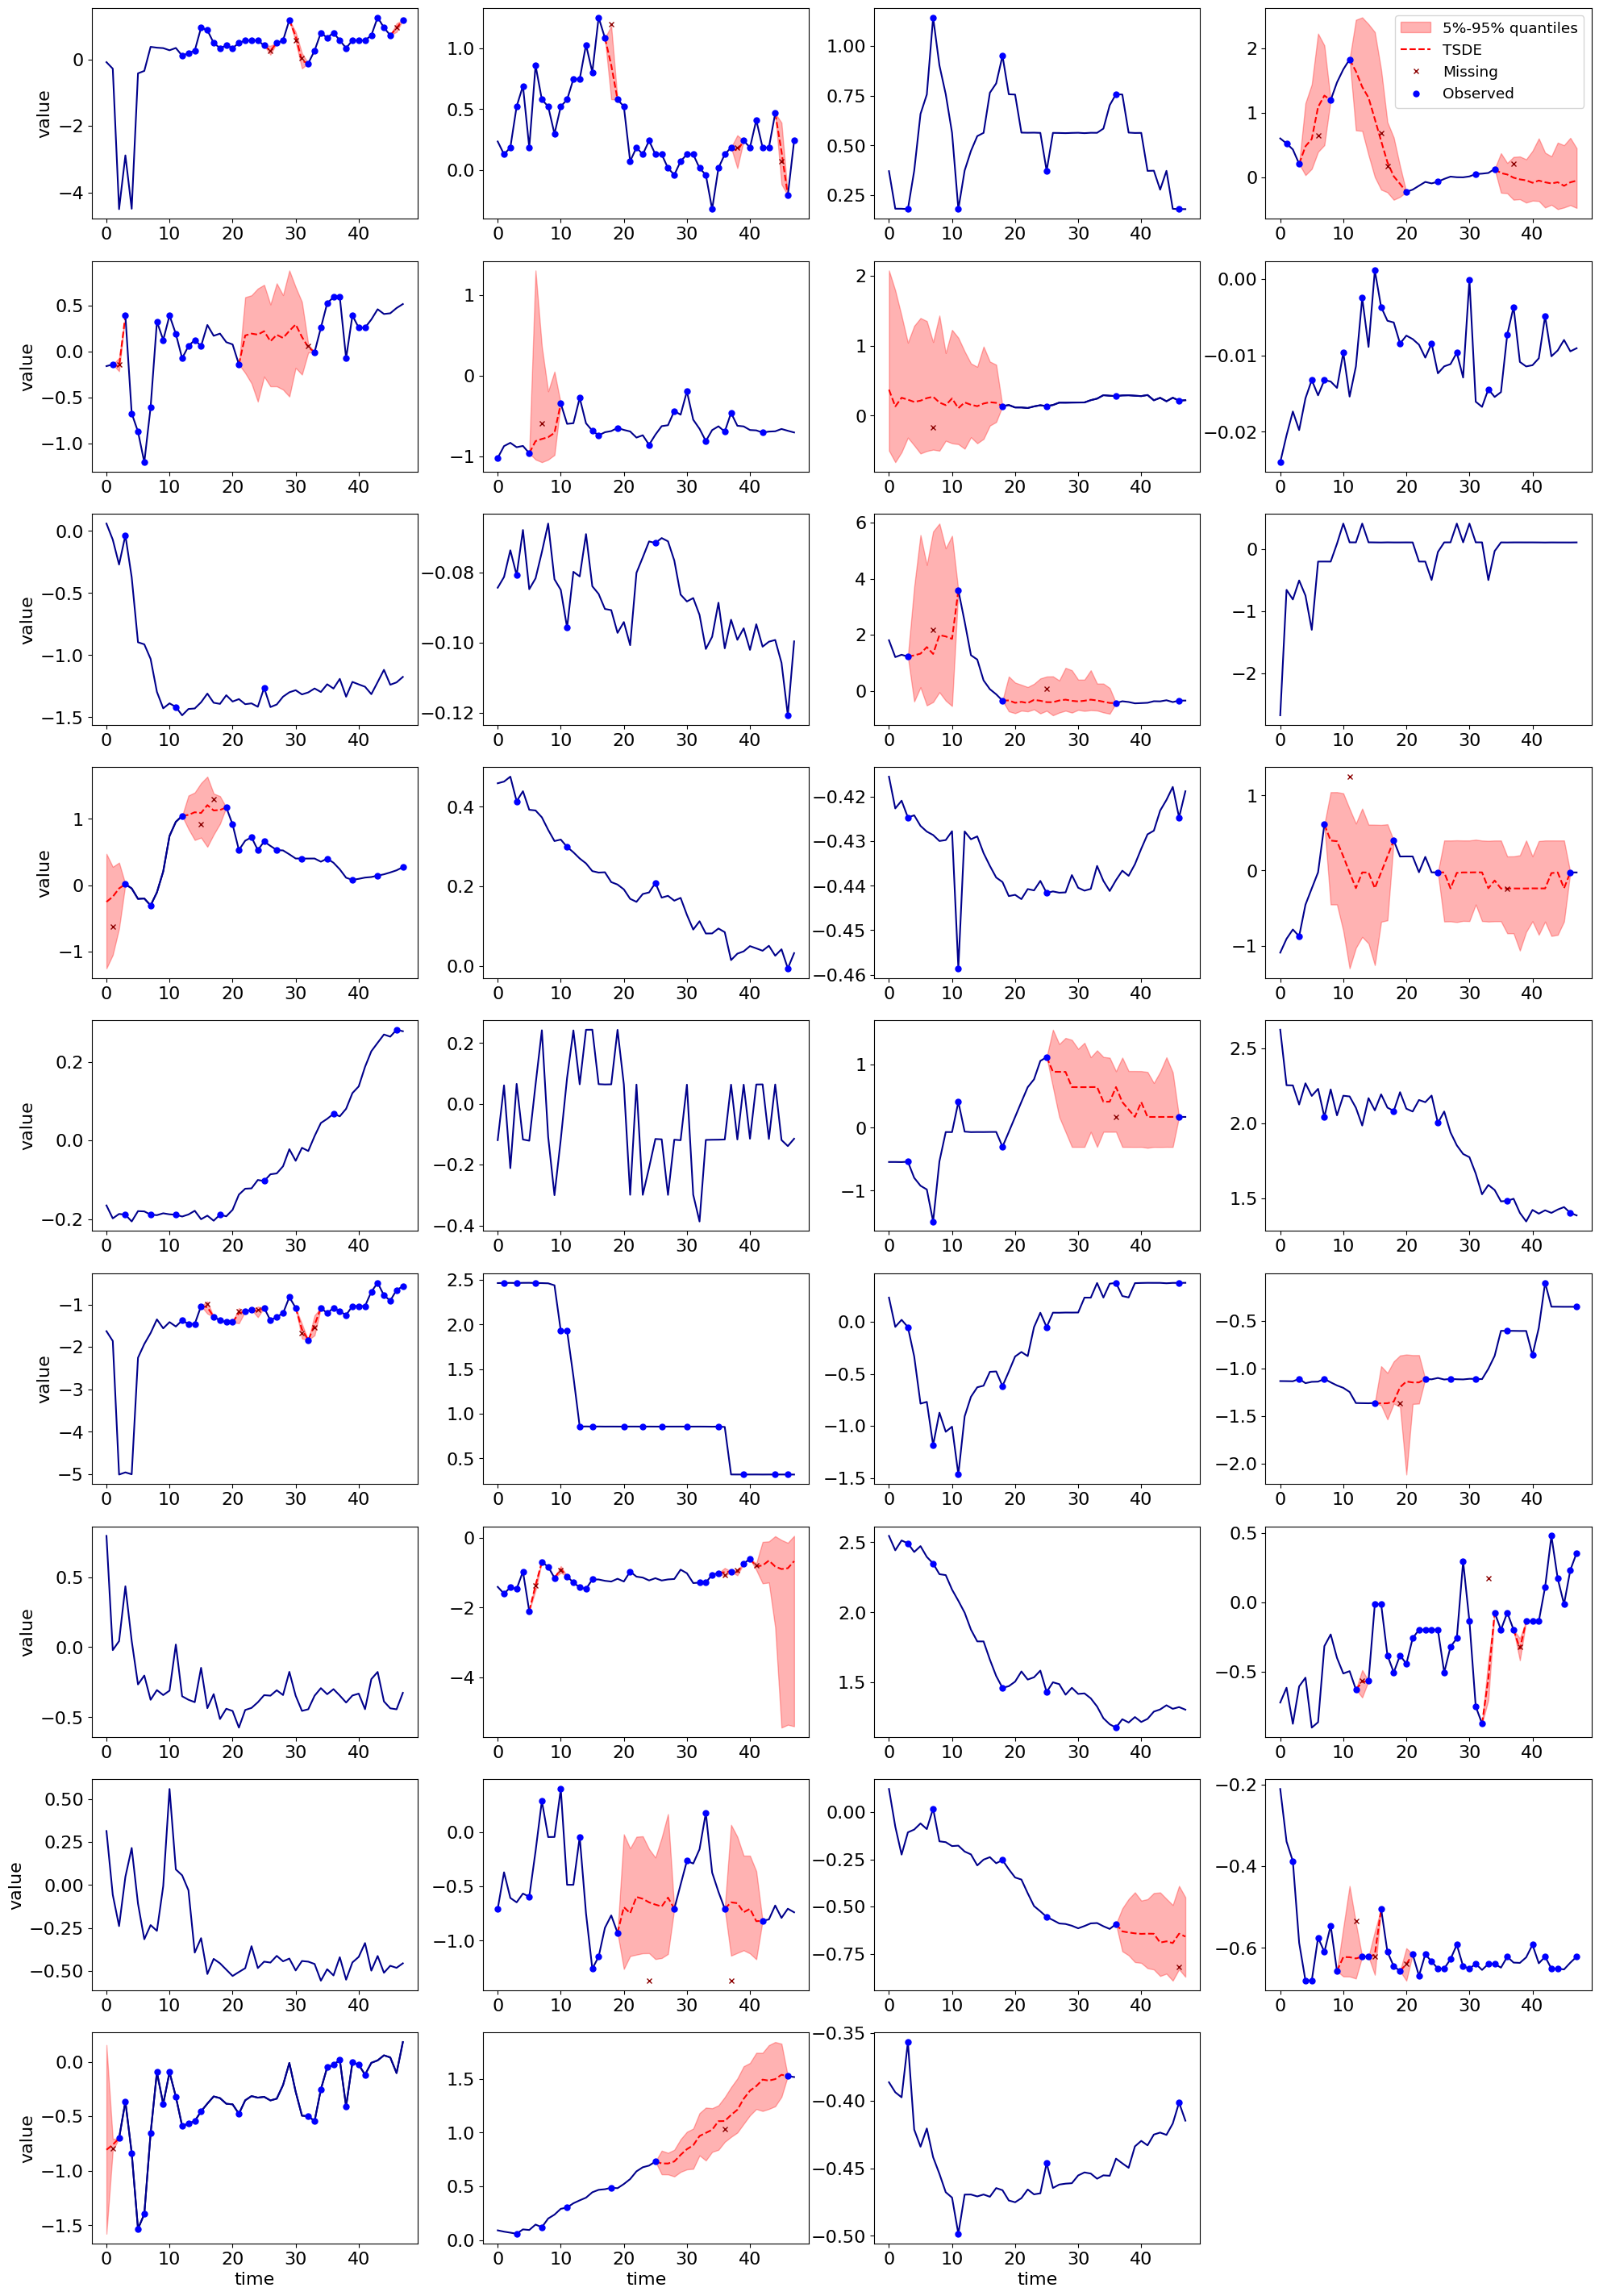

In [137]:
###healthcare###
dataind = 3#change to visualize a different time-series sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])
for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    
    coordinates=[]
    tsde_label_added = False

    previous_x_coord = None
    for x_coord in df.x:
        preceding_blue_dots = df2.x[df2.x < x_coord]
        subsequent_blue_dots = df2.x[df2.x > x_coord]
        
        if not preceding_blue_dots.empty:
            largest_preceding_blue_dot = max(preceding_blue_dots)
        else:
            largest_preceding_blue_dot = 0

        if not subsequent_blue_dots.empty:
            smallest_subsequent_blue_dot = min(subsequent_blue_dots)
        else:
            smallest_subsequent_blue_dot = L
            
        if len(coordinates)!=0 and coordinates[-1][1]>=largest_preceding_blue_dot:
            coordinates[-1] = (coordinates[-1][0],smallest_subsequent_blue_dot)
        elif (largest_preceding_blue_dot, smallest_subsequent_blue_dot) not in coordinates:
            coordinates.append((largest_preceding_blue_dot, smallest_subsequent_blue_dot))
        else:
            print()
    for elt in coordinates:
        
        if not tsde_label_added:
            axes[row][col].fill_between(range(0,L)[elt[0]:elt[1]+1], quantiles_imp[0][dataind,:,k][elt[0]:elt[1]+1],quantiles_imp[4][dataind,:,k][elt[0]:elt[1]+1],
                    color='red', alpha=0.3, label='5%-95% quantiles')
            axes[row][col].plot(range(0,L)[elt[0]:elt[1]+1], quantiles_imp[2][dataind,:,k][elt[0]:elt[1]+1], color = 'red',linestyle='--', label='TSDE')
            tsde_label_added=True
        else:
            axes[row][col].fill_between(range(0,L)[elt[0]:elt[1]+1], quantiles_imp[0][dataind,:,k][elt[0]:elt[1]+1],quantiles_imp[4][dataind,:,k][elt[0]:elt[1]+1],
                    color='red', alpha=0.3)
            axes[row][col].plot(range(0,L)[elt[0]:elt[1]+1], quantiles_imp[2][dataind,:,k][elt[0]:elt[1]+1], color = 'red',linestyle='--')
    prev_index = 0
    for i, elt in enumerate(coordinates):
            if i == len(coordinates)-1:
                axes[row][col].plot(range(0,L)[elt[1]:], quantiles_imp[2][dataind,:,k][elt[1]:], color = 'darkblue',linestyle='solid')
            if elt[0]!=0:
                axes[row][col].plot(range(0,L)[prev_index:elt[0]+1], quantiles_imp[2][dataind,:,k][prev_index:elt[0]+1], color = 'darkblue',linestyle='solid')
                prev_index=elt[1]
            else:
                if len(coordinates)!=1:
                    stop_index = coordinates[1][0]
                    axes[row][col].plot(range(0,L)[elt[1]:stop_index+1], quantiles_imp[2][dataind,:,k][elt[1]:stop_index+1], color = 'darkblue',linestyle='solid')
                    prev_index=elt[1]
                else:
                    axes[row][col].plot(range(0,L)[elt[1]:], quantiles_imp[2][dataind,:,k][elt[1]:], color = 'darkblue',linestyle='solid')
                    
    if len(coordinates)==0:
        axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'darkblue',linestyle='solid')
    axes[row][col].plot(df.x,df.val, color = 'darkred',marker = 'x', linestyle='None', markersize=5, label='Missing')
    axes[row][col].plot(df2.x,df2.val, color = 'b',marker = 'o', linestyle='None', markersize=5, label='Observed')
    tsde_legend = mlines.Line2D([], [], color='red', linestyle='--', label='TSDE')

    
    if row == 8:
        plt.setp(axes[8, col], xlabel='time')
        
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
axes[0][3].legend(loc='upper right', fontsize='small')


# Save the plot to a PDF file
plt.savefig("imputation.pdf", format='pdf')